## Algoritmo de Clusterização Flower

### Tratamento dos dados

In [1]:
import numpy as np
import pandas as pd
import csv
import random
import time
import sqlite3
import difflib
import pm4py
import pygad
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.objects.conversion.process_tree import converter
from pm4py.visualization.bpmn import visualizer as bpmn_visualization
from scipy import stats
from datetime import datetime

In [4]:
'''
#LOG BPI 2012 
from pm4py.objects.log.importer.xes import importer as xes_importer
#log_xes = pm4py.read_xes("BPI_Challenge_2012.xes")
log_xes = xes_importer.apply('BPI_Challenge_2012.xes')
df_pd = pm4py.convert_to_dataframe(log_xes)
df_pd


X_ = df_pd[['concept:name','case:concept:name', 'time:timestamp']]
log = pm4py.format_dataframe(X_, case_id='concept:name', activity_key='case:concept:name', timestamp_key='time:timestamp')
tree = pm4py.algo.discovery.inductive.variants.im.algorithm.apply_tree(log)
tree = pm4py.discover_process_tree_inductive(log)
bpmn_graph = pm4py.convert_to_bpmn(tree)
pm4py.view_bpmn(bpmn_graph)
'''

'\n#LOG BPI 2012 \nfrom pm4py.objects.log.importer.xes import importer as xes_importer\n#log_xes = pm4py.read_xes("BPI_Challenge_2012.xes")\nlog_xes = xes_importer.apply(\'BPI_Challenge_2012.xes\')\ndf_pd = pm4py.convert_to_dataframe(log_xes)\ndf_pd\n'

## Pré-Processamento 

In [5]:
from pm4py.objects.log.importer.xes import importer as xes_importer
log_xes = xes_importer.apply('dados_limpos_UTF8.xes')
#Carregando os dados da base
dados = sqlite3.connect('dados.db')
cursor = dados.cursor()
# Consulta teste realizada utilizando somente SQLite
#cursor.execute("SELECT identificação, situacao, destino, transicao FROM log WHERE assunto='REGIME ESPECIAL DE TRIBUTAÇÃO - ALIMENTOS E CONGÊNERES' AND ano='2018' ORDER BY datahoracadastro AND identificação")
#print(cursor.fetchall())
df = pd.read_sql_query("SELECT identificação, situacao, destino, datahoracadastro FROM log WHERE assunto='REGIME ESPECIAL DE TRIBUTAÇÃO - ALIMENTOS E CONGÊNERES' ORDER BY datahoracadastro AND identificação",dados)
print('Número de eventos: ', len(df))
print('Número de traces: ', len(df['identificação'].unique()))
df = df.rename(columns={'identificação':'caseId','datahoracadastro':'cadastro'}) 

#----------------------------------------------------------
# LIMPEZA: localiza pares de situações similares.
def all_similar_pairs(strings, cutoff=0.85):
    strings = strings.unique()
    result = []
    for i,s in enumerate(strings):
        r = difflib.get_close_matches(s, strings[i:], cutoff=cutoff)
        if len(r) > 1:
            result.append(r)
    result = [frozenset(s) for s in result]
    return result

print(all_similar_pairs(df.situacao, 0.7))

#----------------------------------------------------------
# Agrupamento das situações consideradas similares
df = df.replace({'situacao': {
    'REDISTRIBUÍDO': 'DISTRIBUÍDO',
    'REDIRECIONADO': 'DISTRIBUÍDO',
    'TRANSFERIDO': 'DISTRIBUÍDO',
    'ATO DECLARATÓRIO ASSINADO': 'DECLARAÇÃO ASSINADA',
    'CIENTE': 'CONTRIBUINTE CIENTE',
    'PROCESSO ANALISADO': 'ANALISADO'
    }})
print(np.sort(df.situacao.unique()))

#----------------------------------------------------------
# Inclui a coluna 'atividade' como a concatenação do destino com a situacao
df['atividade'] = df[['destino','situacao']].agg('-'.join, axis=1)

#----------------------------------------------------------
#Codificando atividades para valor inteiro (Utilizar somente para dados privados)
atv = df['atividade'].unique()
for i in range(df['atividade'].shape[0]):
    j = 0
    while(j<len(atv)):
        if(df['atividade'][i] == atv[j]):
            df['atividade'][i] = str(j)
            j = len(atv)
        else:
            j+=1

#----------------------------------------------------------
# REMOVER SEQUÊNCIAS DE ATIVIDADES IGUAIS DE UM MESMO CASE_ID. ATRIBIR ULTIMA DATAHORACADASTRO DA SEQUÊNCIA. 
duplicated = (df['situacao'] == df['situacao'].shift(1)) & (df['caseId'] == df['caseId'].shift(1))
first_id = 0
for id in df.index:
    if duplicated[id]:
        df.at[first_id,'cadastro'] = df.loc[id,'cadastro']
    else:
        first_id = id
df = df[~duplicated]

parsing log, completed traces ::   0%|          | 0/1391 [00:00<?, ?it/s]

Número de eventos:  34110
Número de traces:  1391
[frozenset({'DISTRIBUÍDO', 'REDISTRIBUÍDO'}), frozenset({'PARECER ASSINADO', 'DESPACHO ASSINADO'}), frozenset({'AGUARDANDO ASSINATURA DO COORDENADOR', 'AGUARDANDO ASSINATURA DO CONSULTORIA', 'AGUARDANDO ASSINATURA DO ORIENTADOR'}), frozenset({'AGUARDANDO DOCUMENTO E/OU INFORMAÇÕES DO CONTRIBUINTE', 'AGUARDANDO CIÊNCIA DO CONTRIBUINTE', 'AGUARDANDO ASSINATURA DO CONTRIBUINTE'}), frozenset({'ARQUIVADO', 'DESARQUIVADO'}), frozenset({'AGUARDANDO DOCUMENTO E/OU INFORMAÇÕES DO CONTRIBUINTE', 'AGUARDANDO DOCUMENTO/INFORMAÇÃO'}), frozenset({'AGUARDANDO ANÁLISE DO COORDENADOR', 'AGUARDANDO ASSINATURA DO CONSULTORIA', 'AGUARDANDO ANÁLISE DO CONSULTORIA'}), frozenset({'ATO DECLARATÓRIO ASSINADO', 'DECLARAÇÃO ASSINADA', 'ATO DE APROVAÇÃO ASSINADO'}), frozenset({'AGUARDANDO APROVAÇÃO', 'AGUARDANDO PROVIDÊNCIAS SEFAZ', 'AGUARDANDO PROVIDÊNCIAS'}), frozenset({'AGUARDANDO ANÁLISE DO COORDENADOR', 'AGUARDANDO ASSINATURA DO COORDENADOR', 'AGUARDANDO ASSI

## Funções do algoritmo 

In [6]:
#------------------------------------------Novas Funções-----------------------------------------------------------
import pkgutil
from pm4py import util as pmutil
from pm4py.algo.discovery.dfg.variants import native as dfg_inst
from pm4py.algo.discovery.inductive.util import tree_consistency
from pm4py.algo.discovery.inductive.util.petri_el_count import Counts
from pm4py.algo.discovery.inductive.variants.im.data_structures import subtree_plain as subtree
from pm4py.algo.discovery.inductive.variants.im.util import get_tree_repr_implain
from pm4py.objects.conversion.log import converter
from pm4py.objects.conversion.process_tree import converter as tree_to_petri
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.objects.log.util import filtering_utils
from pm4py.objects.process_tree.utils import generic
from pm4py.objects.process_tree.utils.generic import tree_sort
from pm4py.statistics.attributes.log import get as attributes_get
from pm4py.statistics.end_activities.log import get as end_activities_get
from pm4py.statistics.start_activities.log import get as start_activities_get
from pm4py.util import exec_utils
from pm4py.util import variants_util
from pm4py.util import xes_constants
from pm4py.util import constants
from enum import Enum


class Parameters(Enum):
    ACTIVITY_KEY = constants.PARAMETER_CONSTANT_ACTIVITY_KEY
    START_TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY
    TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_TIMESTAMP_KEY
    CASE_ID_KEY = constants.PARAMETER_CONSTANT_CASEID_KEY
    NOISE_THRESHOLD = "noiseThreshold"
    EMPTY_TRACE_KEY = "empty_trace"
    ONCE_PER_TRACE_KEY = "once_per_trace"
    CONCURRENT_KEY = "concurrent"
    STRICT_TAU_LOOP_KEY = "strict_tau_loop"
    TAU_LOOP_KEY = "tau_loop"


def apply_tree_variants(variants,return_process_tree, parameters=None):
    """
    Apply the IM algorithm to a dictionary of variants obtaining a process tree

    Parameters
    ----------
    variants
        Variants
    parameters
        Parameters of the algorithm, including:
            Parameters.ACTIVITY_KEY -> attribute of the log to use as activity name
            (default concept:name)

    Returns
    ----------
    process_tree
        Process tree
    """
    log = EventLog()
    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters, xes_constants.DEFAULT_NAME_KEY)

    var_keys = list(variants.keys())
    for var in var_keys:
        trace = Trace()
        activities = variants_util.get_activities_from_variant(var)
        for act in activities:
            trace.append(Event({activity_key: act}))
        log.append(trace)

    return apply_tree(log, return_process_tree, parameters=parameters)
#----------------------------------------------------------
def apply_tree(log, return_process_tree, parameters=None):
    if parameters is None:
        parameters = {}

    if pkgutil.find_loader("pandas"):
        import pandas as pd
        from pm4py.statistics.variants.pandas import get as variants_get
    
        if type(log) is pd.DataFrame:
            vars = variants_get.get_variants_count(log, parameters=parameters)
            return apply_tree_variants(vars, return_process_tree, parameters=parameters)

    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters,
                                              pmutil.xes_constants.DEFAULT_NAME_KEY)

    log = converter.apply(log, parameters=parameters)
    # since basic IM is influenced once per variant, it makes sense to keep one trace per variant
    log = filtering_utils.keep_one_trace_per_variant(log, parameters=parameters)
    # keep only the activity attribute (since the others are not used)
    log = filtering_utils.keep_only_one_attribute_per_event(log, activity_key)

    dfg = [(k, v) for k, v in dfg_inst.apply(log, parameters=parameters).items() if v > 0]
    c = Counts()
    activities = attributes_get.get_attribute_values(log, activity_key)
    start_activities = list(start_activities_get.get_start_activities(log, parameters=parameters).keys())
    end_activities = list(end_activities_get.get_end_activities(log, parameters=parameters).keys())
    contains_empty_traces = False
    traces_length = [len(trace) for trace in log]
    if traces_length:
        contains_empty_traces = min([len(trace) for trace in log]) == 0

    recursion_depth = 0
    sub = subtree.make_tree(log, dfg, dfg, dfg, activities, c, recursion_depth, 0.0, start_activities,
                            end_activities,
                            start_activities, end_activities, parameters)
    if(return_process_tree):
        #### utilizar quando quiser gerar a process_tree
        process_tree = get_tree_repr_implain.get_repr(sub, 0, contains_empty_traces=contains_empty_traces)
        # Ensures consistency to the parent pointers in the process tree
        tree_consistency.fix_parent_pointers(process_tree)
        # Fixes a 1 child XOR that is added when single-activities flowers are found
        tree_consistency.fix_one_child_xor_flower(process_tree)
        # folds the process tree (to simplify it in case fallthroughs/filtering is applied)
        process_tree = generic.fold(process_tree)
        # sorts the process tree to ensure consistency in different executions of the algorithm
        tree_sort(process_tree)

        # CRISTON: retorna também a subtree, pois contém os sub-logs
        # return process_tree
        return process_tree,sub
    return sub

def apply_sublog_tree(sub_, return_process_tree, parameters=None):
    if parameters is None:
        parameters = {}

    if pkgutil.find_loader("pandas"):
        import pandas as pd
        from pm4py.statistics.variants.pandas import get as variants_get
    
        if type(sub_.log) is pd.DataFrame:
            vars = variants_get.get_variants_count(sub_.log, parameters=parameters)
            return apply_tree_variants(vars, return_process_tree, parameters=parameters)

    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters,
                                              pmutil.xes_constants.DEFAULT_NAME_KEY)

    log = sub_.log
    # since basic IM is influenced once per variant, it makes sense to keep one trace per variant
    log = filtering_utils.keep_one_trace_per_variant(log, parameters=parameters)
    # keep only the activity attribute (since the others are not used)
    log = filtering_utils.keep_only_one_attribute_per_event(log, activity_key)

    dfg = [(k, v) for k, v in dfg_inst.apply(log, parameters=parameters).items() if v > 0]
    c = Counts()
    activities = attributes_get.get_attribute_values(log, activity_key)
    start_activities = list(start_activities_get.get_start_activities(log, parameters=parameters).keys())
    end_activities = list(end_activities_get.get_end_activities(log, parameters=parameters).keys())
    contains_empty_traces = False
    traces_length = [len(trace) for trace in log]
    if traces_length:
        contains_empty_traces = min([len(trace) for trace in log]) == 0

    recursion_depth = 0
    
    sub = subtree.make_tree(sub_.log, dfg, dfg, dfg, activities, c, recursion_depth, 0.0, start_activities,
                            end_activities,
                            start_activities, end_activities, parameters)
    #### utilizar quando quiser gerar a process_tree
    process_tree = get_tree_repr_implain.get_repr(sub, 0, contains_empty_traces=contains_empty_traces)
    # Ensures consistency to the parent pointers in the process tree
    tree_consistency.fix_parent_pointers(process_tree)
    # Fixes a 1 child XOR that is added when single-activities flowers are found
    tree_consistency.fix_one_child_xor_flower(process_tree)
    # folds the process tree (to simplify it in case fallthroughs/filtering is applied)
    process_tree = generic.fold(process_tree)
    # sorts the process tree to ensure consistency in different executions of the algorithm
    tree_sort(process_tree)
    
    # CRISTON: retorna também a subtree, pois contém os sub-logs
    # return process_tree
    return process_tree

#----------------------------------------------------------
#Criando a Matriz de distância de edição dos Traces com levenshtein
from Levenshtein import distance as lev 

def matriz_distancia(traces):
    #sublog tem que vir como traces
    distances = np.zeros((traces.size, traces.size))

    for i in range(distances.shape[0]):
        for j in range(i+1, distances.shape[1]):
            distances[i][j] = lev(traces['str'][i], traces['str'][j])
            distances[j][i] = distances[i][j]
    return distances

#----------------------------------------------------------
#Deve receber um dataframe pandas
def print_tree(s, return_process_tree):
    tree = apply_sublog_tree(s,return_process_tree)
    #pm4py.view_process_tree(tree)
    return tree

#----------------------------------------------------------
def gerar_traces_sublog(sub):
    sub_log_df = pd.DataFrame(columns=['caseId','atividades','cadastro'])

    k=0
    for i in range(len(sub.log)):
        grupo=pd.DataFrame(data=sub.log[i])
        for j in range(len(grupo)):
            sub_log_df.loc[len(sub_log_df)]=[k,grupo['concept:name'][j],X['cadastro'][0]]
        k+=1

    #traces = sub_log_df.groupby(sub_log_df.caseId)['atividades'].agg(str=lambda x: '-'.join(x))
    #sub_log_df é um dataframe 
    #traces é o conjunto de atividades organizadas linearmente por trace
    return sub_log_df#, traces
#----------------------------------------------------------
#Gera os clusters de sublog retornando o clusterid ao qual cada trace pertence
from Bio.Cluster import kmedoids

def cluster_sublog(dist):
    clusterid, error, nfound = kmedoids(dist)
    return clusterid
#----------------------------------------------------------
def Buscar_Cluster(clusters, sub_df, groups, id_clusters_selecionados):
    ids = sub_df['caseId'].unique()
    cluster_sub_esq = pd.DataFrame(columns=['caseId', 'atividades','cadastro'])
    cluster_sub_dir = pd.DataFrame(columns=['caseId', 'atividades','cadastro'])

    for i in ids:
        grupo = groups.get_group(i)
        if(clusters[i]==id_clusters_selecionados[0]):
            for j in range (grupo.shape[0]):
                cluster_sub_esq.loc[len(cluster_sub_esq)] = grupo.iloc[j]
        else:
            for j in range (grupo.shape[0]):
                cluster_sub_dir.loc[len(cluster_sub_dir)] = grupo.iloc[j]
                
    log = pm4py.format_dataframe(cluster_sub_esq, case_id='caseId', activity_key='atividades', timestamp_key='cadastro')
    cluster_sub_esq = apply_tree(log, False)
    log = pm4py.format_dataframe(cluster_sub_dir, case_id='caseId', activity_key='atividades', timestamp_key='cadastro')
    cluster_sub_dir = apply_tree(log, False)
    return cluster_sub_esq, cluster_sub_dir

#----------------------------------------------------------
def gerar_subs_esq_dir(sub):
    sub_df= gerar_traces_sublog(sub)
    groups = sub_df.groupby(sub_df.caseId)
    dist =  matriz_distancia(traces)
    clusters = cluster_sublog(dist)
    id_clusters_selecionados=sorted(set(clusters))
    sublog_esq, sublog_dir = Buscar_Cluster(clusters, sub_df, groups, id_clusters_selecionados)
    return sublog_esq, sublog_dir
#----------------------------------------------------------
def find_fall_through(r, MIN_TRACES):

    if r is None: return False, None
    
    # if not has_fall_through and len(r.log) >= MIN_TRACES:
    if len(r.log) >= MIN_TRACES and (r.detected_cut == 'flower' or r.detected_cut == 'tau_loop' or r.detected_cut == 'strict_tau_loop'):
        print(r.detected_cut, len(r.children), len(r.log))
        return (True, r)
    
    # has_fall_through, sublog = False, None
    for c in r.children:
        child_has_fall_through, child_sublog = find_fall_through(c,MIN_TRACES)
        if child_has_fall_through:
            return True, child_sublog

    return False, None
#----------------------------------------------------------
def remove_fall_through(s, sublog_fall_through, novo_sublog):    
    if s is None: return None
    if s == sublog_fall_through:
        print("Iguais")
        return novo_sublog

    for t in range(len(s.children)):
        s.children[t] = remove_fall_through(s.children[t], sublog_fall_through, novo_sublog)
    
    return s
#----------------------------------------------------------
def teste(s, sublog_fall_through):    

    if s == sublog_fall_through:
        print("TEM")

    for t in range(len(s.children)):
        if(s.children[t]!=None):
            teste(s.children[t], sublog_fall_through)

## Principal

In [7]:
def list_trees_IM_cluster(s,MIN_TRACES):
   
    has_fall_through, sublog = find_fall_through(s,MIN_TRACES)
    if has_fall_through:
        s_esq, s_dir = gerar_subs_esq_dir(s)
        list_esq = list_trees_IM_cluster(s_esq,MIN_TRACES)
        list_dir = list_trees_IM_cluster(s_dir,MIN_TRACES)

        List = []
        list_esq_dir = list_esq + list_dir
        for t in list_esq_dir:
            aux = s.__deepcopy__()
            List.append(remove_fall_through(aux, sublog, t))
        return List
    return [s]

In [52]:
ids = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,12]
atv = ['a', 'b', 'c', 'd','a', 'b', 'c', 'd','a', 'b', 'c', 'd','a', 'c', 'b', 'd','a', 'c', 'b', 'd','a', 'c', 'b', 'd','a', 'c', 'b', 'd','a', 'b', 'c', 'e', 'f', 'b', 'c', 'd','a', 'b', 'c', 'e', 'f', 'b', 'c', 'd','a', 'c', 'b', 'e', 'f', 'b', 'c', 'd','a', 'c', 'b', 'e', 'f', 'b', 'c', 'd','a', 'b', 'c', 'e', 'f', 'c', 'b', 'd','a', 'c', 'b', 'e', 'f', 'b', 'c','e', 'f', 'c','d']
time = X['cadastro'][0:len(ids)]
df_teste = pd.DataFrame(zip(ids, atv, time), columns = ['caseId', 'atividade','cadastro'])
X = df_teste[['caseId', 'atividade','cadastro']]
groups = X.groupby(X.caseId)
traces = X.groupby(X.caseId)['atividade'].agg(str=lambda x: '-'.join(x))
log = pm4py.format_dataframe(X, case_id='caseId', activity_key='atividade', timestamp_key='cadastro')
tree, sub = apply_tree(log, True)

In [56]:
#Executar até aqui para ter o problema
#subs é uma lista de todas as subtreeplain's geradas após a remoção do fall through
subs = list_trees_IM_cluster(sub, 8)

strict_tau_loop 1 8
Iguais


In [60]:
subs[0]==subs[1]

False

O algoritmo gera dois subtreeplain diferentes, mas como pode-se observar a seguir os dois BPM's são iguais

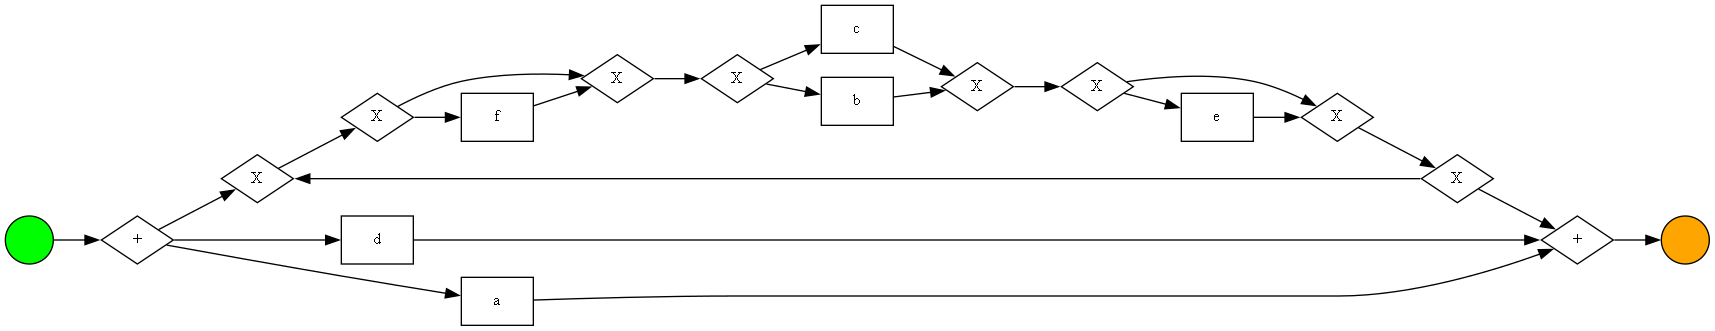

In [58]:
tree = print_tree(subs[0], True)
bpmn_graph = pm4py.convert_to_bpmn(tree)
gviz = bpmn_visualization.apply(bpmn_graph)
bpmn_visualization.view(gviz)

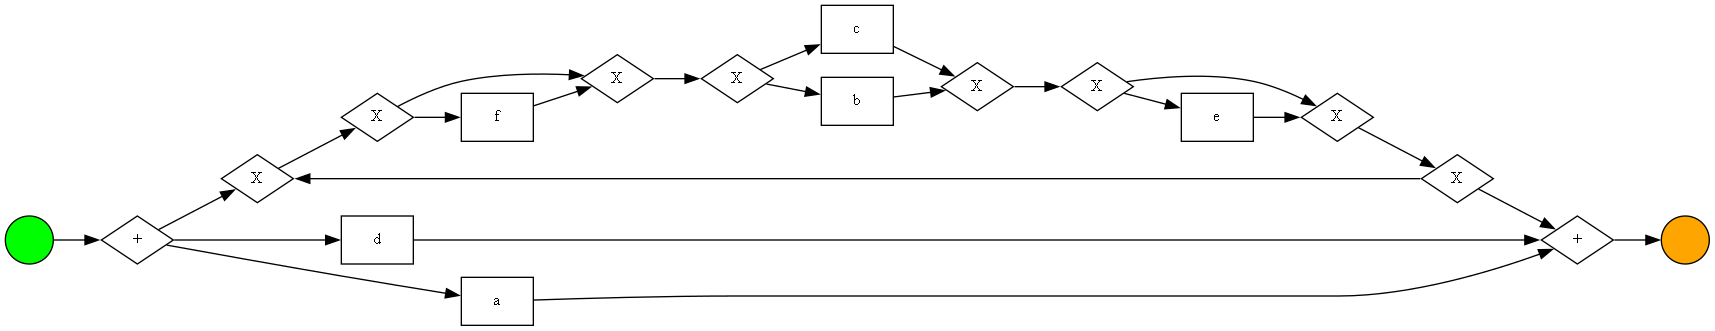

In [59]:
tree = print_tree(subs[1], True)
bpmn_graph = pm4py.convert_to_bpmn(tree)
gviz = bpmn_visualization.apply(bpmn_graph)
bpmn_visualization.view(gviz)

# Algoritmo Oficial

In [27]:
'''
X = df[['caseId', 'atividade','cadastro']]
X = X[0:1500]
groups = X.groupby(X.caseId)
traces = X.groupby(X.caseId)['atividade'].agg(str=lambda x: '-'.join(x))
log = pm4py.format_dataframe(X, case_id='caseId', activity_key='atividade', timestamp_key='cadastro')
tree, sub = apply_tree(log, True)
'''

In [24]:
'''
MIN_TRACES_LIST = [32,64,128,256]
total_traces = [2000,5000,10000]
mostrar = False
for i in MIN_TRACES_LIST:
    print("Modelo com MIN_TRACES = "+str(i))
    for j in (total_traces):
        print("Modelo com total de traces "+str(j))
        X = df[['caseId', 'atividade','cadastro']]
        X = X[0:j]
        groups = X.groupby(X.caseId)
        traces = X.groupby(X.caseId)['atividade'].agg(str=lambda x: '-'.join(x))


        log = pm4py.format_dataframe(X, case_id='caseId', activity_key='atividade', timestamp_key='cadastro')
        sub = apply_tree(log, False)
        subs = list_trees_IM_cluster(sub,i)
        
        if mostrar:
            for k in range(len(subs)):
                print("____________________BPM_"+str(k)+"____________________")
                tree = print_tree(subs[k], True)
                bpmn_graph = pm4py.convert_to_bpmn(tree)
                gviz = bpmn_visualization.apply(bpmn_graph)
                bpmn_visualization.view(gviz)
    print("______________________________________________________________________________________________________________________")
    '''

'\nMIN_TRACES_LIST = [32,64,128,256]\ntotal_traces = [2000,5000,10000]\nmostrar = False\nfor i in MIN_TRACES_LIST:\n    print("Modelo com MIN_TRACES = "+str(i))\n    for j in (total_traces):\n        print("Modelo com total de traces "+str(j))\n        X = df[[\'caseId\', \'atividade\',\'cadastro\']]\n        X = X[0:j]\n        groups = X.groupby(X.caseId)\n        traces = X.groupby(X.caseId)[\'atividade\'].agg(str=lambda x: \'-\'.join(x))\n\n\n        log = pm4py.format_dataframe(X, case_id=\'caseId\', activity_key=\'atividade\', timestamp_key=\'cadastro\')\n        sub = apply_tree(log, False)\n        subs = list_trees_IM_cluster(sub,i)\n        \n        if mostrar:\n            for k in range(len(subs)):\n                print("____________________BPM_"+str(k)+"____________________")\n                tree = print_tree(subs[k], True)\n                bpmn_graph = pm4py.convert_to_bpmn(tree)\n                gviz = bpmn_visualization.apply(bpmn_graph)\n                bpmn_visuali

In [81]:
'''
t = []
for i in range(len(subs)):
    t.append(pm4py.discover_process_tree_inductive(subs[i].log))
# Salvando Process Trees do subs gerados
for i in range(len(subs)):
    tree = print_tree(subs[i], True)
    pm4py.write_ptml(tree, "Trees/tree_"+str(i)+".ptml")
'''